# Causal Inference in Decision Intelligence – Part 9: DoWhy Library as a Causal Inference Framework

Link to the article:  [DoWhy Library as a Causal Inference Framework](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-9-dowhy-library-zinoviev-snd8c)

## Import the Libraries

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
from collections import OrderedDict
import warnings

import numpy as np
import pandas as pd
import networkx as nx

import dowhy.gcm as gcm

from dowhy import CausalModel

from scipy import linalg 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Generate the data

In [2]:
# Set up the colors
COLORS = ['#00B0F0', '#FF0000', '#B0F000']

In [3]:

np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create other variables 
data['Marketing'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Marketing + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)
data = data.drop(columns=['Year', 'Id']) 

## DoWhy framework

### Stage I. Specify the causal graph

In [4]:
# Create the true DAG
G = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Marketing'), 
                  ('Income', 'Sales'), ('Price', 'Sales'), ('Marketing', 'Visits'), ('Visits', 'Sales')])

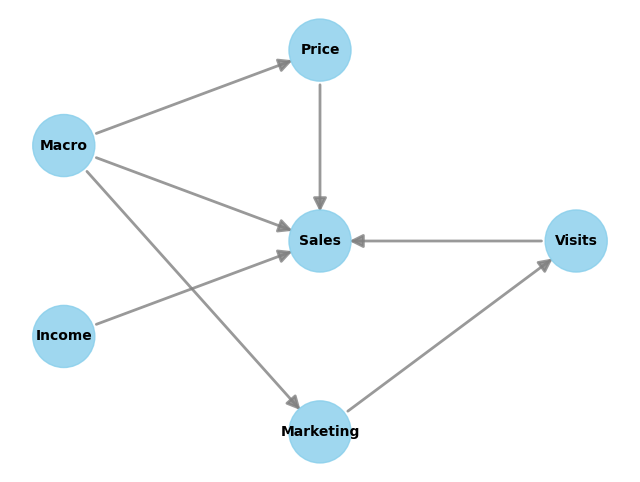

<Figure size 640x480 with 0 Axes>

In [5]:
# Create the causal model
model = CausalModel(data=data,
                     graph=G,
                     treatment="Marketing",
                     outcome="Sales")
model.view_model();

### Stage II. Identify the target estimand

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                      
────────────(E[Sales|Macro])
d[Marketing]                
Estimand assumption 1, Unconfoundedness: If U→{Marketing} and U→Sales then P(Sales|Marketing,Macro,U) = P(Sales|Marketing,Macro)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡    d                 d                ⎤
E⎢─────────(Sales)⋅────────────([Visits])⎥
 ⎣d[Visits]        d[Marketing]          ⎦
Estimand assumption 1, Full-mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)



### Stage III. Estimate causal effect

In [7]:
# Backdoor regression method
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                      
────────────(E[Sales|Macro])
d[Marketing]                
Estimand assumption 1, Unconfoundedness: If U→{Marketing} and U→Sales then P(Sales|Marketing,Macro,U) = P(Sales|Marketing,Macro)

## Realized estimand
b: Sales~Marketing+Macro+Marketing*Income+Marketing*Price
Target units: 

## Estimate
Mean value: 0.37650514278951164
p-value: [4.07277605e-32]
### Conditional Estimates
__categorical__Income  __categorical__Price
(0.999, 2.0]           (8.246, 9.852]          0.467960
                       (9.852, 10.385]         0.414679
                       (10.385, 11.546]        0.329237
                       (11.546, 12.112]        0.256816
                       (12.112, 14.046]        0.202940
(2.0, 3.0]             (8.246, 9.852]          0.757165
                       (9.852, 10.385]         0.703132

In [8]:
# Frontdoor regression method
causal_estimate_front = model.estimate_effect(identified_estimand,
        method_name="frontdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡    d                 d                ⎤
E⎢─────────(Sales)⋅────────────([Visits])⎥
 ⎣d[Visits]        d[Marketing]          ⎦
Estimand assumption 1, Full-mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)

## Realized estimand
b: Sales~Marketing+Macro+Marketing*Income+Marketing*Price
Target units: 

## Estimate
Mean value: 0.37650514278951164
p-value: [4.07277605e-32]
### Conditional Estimates
__categorical__Income  __categorical__Price
(0.999, 2.0]           (8.246, 9.852]          0.467960
                       (9.852

Both Backdoor and Frontdoor estimands return identical estimates of ATE: 0.3765 (close to the real one of 0.4).

### Mediation analysis

In [9]:
modelm = CausalModel(data=data,
                     graph=G,
                     treatment="Marketing",
                     outcome="Sales")

In [10]:
# Natural direct effect (nde)
identified_estimand_nde = modelm.identify_effect(estimand_type="nonparametric-nde",
                                                proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡     d                    ⎤
E⎢────────────(Sales|Visits)⎥
 ⎣d[Marketing]              ⎦
Estimand assumption 1, Mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s except the path {Marketing}→{S,a,l,e,s}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)



In [11]:
# Natural indirect effect (nie)
identified_estimand_nie = modelm.identify_effect(estimand_type="nonparametric-nie",
                                                proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡    d                 d                ⎤
E⎢─────────(Sales)⋅────────────([Visits])⎥
 ⎣d[Visits]        d[Marketing]          ⎦
Estimand assumption 1, Mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s except the path {Marketing}→{S,a,l,e,s}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)



In [12]:
import dowhy.causal_estimators.linear_regression_estimator
causal_estimate_nie = modelm.estimate_effect(identified_estimand_nie,
                                            method_name="mediation.two_stage_regression",
                                            confidence_intervals=True,
                                            test_significance=False,
                                            method_params = {
                                                'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                                'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                            })
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡    d                 d                ⎤
E⎢─────────(Sales)⋅────────────([Visits])⎥
 ⎣d[Visits]        d[Marketing]          ⎦
Estimand assumption 1, Mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s except the path {Marketing}→{S,a,l,e,s}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)

## Realized estimand
(b: Visits~Marketing+Marketing*Income+Marketing*Price)*(b: Sales~Visits+Macro+Visits*Income+Visits*Price)
Target units: ate

## Estimate
Mean value: 0.404037886435121
95.0% confidence interval: (0.36153645662648315, 0.44173919954691265)



The estimated direct effect is 0.41 (compared to the true one of 0.4).

In [13]:
causal_estimate_nde = modelm.estimate_effect(identified_estimand_nde,
                                            method_name="mediation.two_stage_regression",
                                            confidence_intervals=True,
                                            test_significance=False,
                                            method_params = {
                                              'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                              'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                            })
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡     d                    ⎤
E⎢────────────(Sales|Visits)⎥
 ⎣d[Marketing]              ⎦
Estimand assumption 1, Mediation: Visits intercepts (blocks) all directed paths from Marketing to S,a,l,e,s except the path {Marketing}→{S,a,l,e,s}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Marketing} and U→{Visits} then P(Visits|Marketing,U) = P(Visits|Marketing)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Visits} and U→Sales then P(Sales|Visits, Marketing, U) = P(Sales|Visits, Marketing)

## Realized estimand
(b: Sales~Marketing+Macro+Marketing*Income+Marketing*Price) - ((b: Visits~Marketing+Marketing*Income+Marketing*Price)*(b: Sales~Visits+Macro+Visits*Income+Visits*Price))
Target units: ate

## Estimate
Mean value: -0.02753274364560937
95.0% confidence interval: (-0.2093323363206111, 0.10672033513255685)

The estimated indirect effect is -0.037 and it's not statistically different from 0 (compared to the true one of 0).

### Stage IV. Refute estimate

In [14]:
# Placebo refuter
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
       method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:0.37650514278951164
New effect:0.0010411380586545249
p value:0.96



In [15]:
# Random common cause refuter
res_random=model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:0.37650514278951164
New effect:0.37650514278951164
p value:1.0



In [16]:
# Data subsample refuter
res_subset=model.refute_estimate(identified_estimand, causal_estimate_reg,
       method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:0.37650514278951164
New effect:0.37205520223087957
p value:0.86



## Graphical Causal Model (GCM)

### Stage I. Specify the causal graph

In [17]:
# Create the true DAG (the stage is identical to one used for DoWhy framework
G = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Marketing'), 
                  ('Income', 'Sales'), ('Price', 'Sales'), ('Marketing', 'Visits'), ('Visits', 'Sales')])

### Stage II. Build graphical causal model

In [18]:
# Build Structural causal model on top of the causal graph
causal_model = gcm.StructuralCausalModel(G)

In [19]:
# Assign causal mechanisms to each node
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

In [20]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [21]:
# Fit the graphical causal model
gcm.fit(causal_model, data)

Fitting causal mechanism of node Visits: 100%|███████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]


Test permutations of given graph: 100%|████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.15it/s]


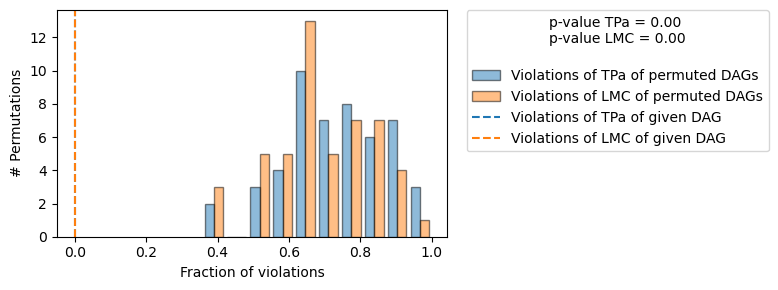

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [31]:
print(gcm.evaluate_causal_model(causal_model, data))

### Stage III. Perform causal tasks

In [24]:
# Estimate average causal effect of macro environment on Sales
np.random.seed(3)
gcm.average_causal_effect(causal_model,
                         'Sales',
                         interventions_alternative={'Macro': lambda x: 1},
                         interventions_reference={'Macro': lambda x: 0},
                         num_samples_to_draw=1000)

In [26]:
# Estimate average causal effect of Loyalty and price on sales
np.random.seed(4)
gcm.average_causal_effect(causal_model,
                         'Sales',
                         interventions_alternative={'Marketing': lambda x: 51, 'Price': lambda x: 11},
                         interventions_reference={'Marketing': lambda x: 50, 'Price': lambda x: 10},
                         num_samples_to_draw=1000)

In [27]:
# Bootstrap confidence intervals for the effect of Price on Sales
np.random.seed(4)
median, intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.average_causal_effect,
                        causal_model,
                        bootstrap_training_data=data,
                        target_node='Sales',
                        interventions_alternative={'Price': lambda x: 11},
                        interventions_reference={'Price': lambda x: 10},
                        num_samples_to_draw=1000))
median, intervals

Estimating bootstrap interval...: 100%|████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.93it/s]


(array([-6.95512034]), array([[-7.46331102, -6.68124008]]))